# Imports

In [ ]:
!pip install grad-cam

In [ ]:
! pip install ttach

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from google.colab import drive
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# Configs

In [ ]:
%matplotlib inline

In [ ]:
BATCH_SIZE = 32
DATA_LOADER_KWARGS = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'pin_memory': True,
    'num_workers': 0,
}

RGB_MEANS = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]

In [ ]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='cuda', index=0)

# Data

In [ ]:
!gdown --id 14D25rvi6Bg74yZ98Uy02Z7ssgcF7ZHdC

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14D25rvi6Bg74yZ98Uy02Z7ssgcF7ZHdC
To: /content/dataset.zip
100% 65.7M/65.7M [00:01<00:00, 50.3MB/s]


In [ ]:
!unzip -q dataset.zip
!rm dataset.zip
!ls

## Create DataLoaders

In [ ]:
transforms = []
import torchvision.transforms as t
transforms.append(t.Resize(256))
transforms.append(t.CenterCrop(224))
transforms.append(t.ToTensor())
transforms.append(t.Normalize(mean=RGB_MEANS,std=RGB_STD))
transforms = torchvision.transforms.Compose(transforms)

transforms

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
train_dataset, val_dataset, test_dataset = None, None, None
all_dataset = torchvision.datasets.ImageFolder('brain-tumor-dataset', transform=transforms)
train_dataset, val_dataset = torch.utils.data.random_split(all_dataset,[int(len(all_dataset)*0.7),
                                                                        int(len(all_dataset)*0.3)])
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [int(len(val_dataset)*(2/3)),
                                                                        int(len(val_dataset)*(1/3))])
train_loader = DataLoader(train_dataset, **DATA_LOADER_KWARGS)
val_loader = DataLoader(val_dataset, **DATA_LOADER_KWARGS)
test_loader = DataLoader(test_dataset, **DATA_LOADER_KWARGS)

print('Train Classes Dist:', np.bincount(np.array(all_dataset.targets)[train_dataset.indices]))
print('Val Classes Dist:  ', np.bincount(np.array(all_dataset.targets)[val_dataset.indices]))
print('Test Classes Dist: ', np.bincount(np.array(all_dataset.targets)[test_dataset.indices]))


Train Classes Dist: [1030 1070]
Val Classes Dist:   [600]
Test Classes Dist:  [300]


In [ ]:
input_shape = tuple(all_dataset[0][0].shape)
num_classes = len(all_dataset.classes)

print('Input Shape =', input_shape)
print('Num of Classes =', num_classes)

Input Shape = (3, 224, 224)
Num of Classes = 2


## Visualizing

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unnormalize = UnNormalize(RGB_MEANS, RGB_STD)

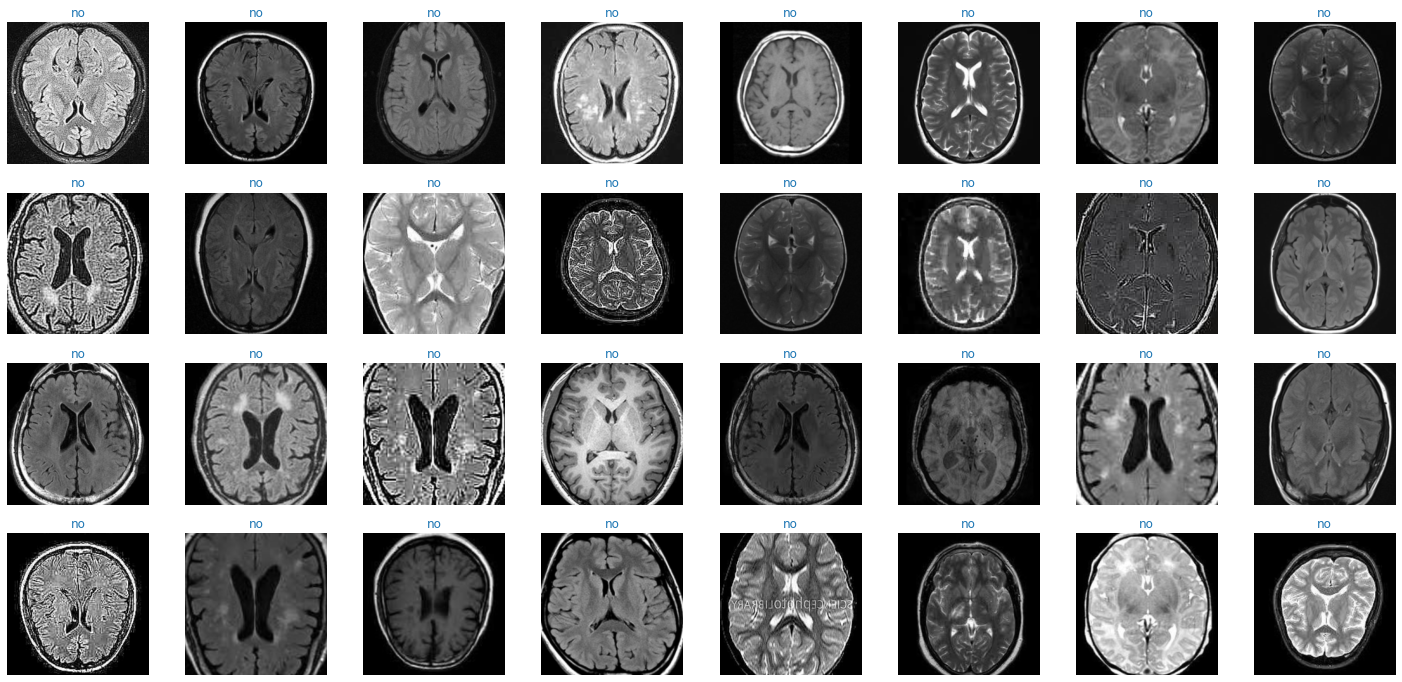

In [ ]:
vis_num_images = 32
vis_images_per_row = 8

np.random.seed(6)
vis_image_indexes = np.random.choice(test_dataset.indices, size=vis_num_images, replace=False)
vis_images, vis_labels = [], []
for i in vis_image_indexes:
    new_image, new_label = all_dataset[i]
    vis_images.append(np.moveaxis(unnormalize(new_image).numpy(), 0, -1))
    vis_labels.append(new_label)

fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)

for i in range(vis_num_images):
    ax = fig.add_subplot(gs[i // vis_images_per_row, i % vis_images_per_row])
    ax.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
    ax.axis('off')
    ax.imshow(vis_images[i])

plt.show()

# Train & Test Methods

## Train

In [ ]:
def train(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_log = []
    test_log = []
    plt.figure(figsize=(16, 8))

    for epoch in range(1, num_epochs+1):
        train_loss = []
        model.train()
        for inputs, targets in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.get_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))

        test_loss = []
        model.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc='Validation', leave=False):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = model.get_loss(outputs, targets)
                test_loss.append(loss.item())
        test_log.append(np.mean(test_loss))

        plt.clf()
        plt.title(f'Epoch {epoch}/{num_epochs}')
        plt.plot(range(1, epoch+1), train_log, color='C0', label='Train')
        plt.plot(range(1, epoch+1), test_log, color='C1', label='Val')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    plt.close()

## Test

In [ ]:
def test(model, data_loader):
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc='Predicting', leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            if type(outputs) is tuple: outputs = outputs[-1]
            outputs = outputs.detach().cpu().numpy()

            y_true += targets.detach().cpu().numpy().tolist()
            y_pred += np.argmax(outputs, axis=-1).tolist()

    print(classification_report(y_true, y_pred, target_names=all_dataset.classes))

# Model Definition

In [ ]:
class ConvClassifier(nn.Module):
    def __init__(self, input_shape, num_classes, convs, fcs, conv_drop_rate=None, fc_drop_rate=None):
        super(ConvClassifier, self).__init__()

        # Convolution Layers
        self.conv_layers = None
        if convs == 'vgg16':
            vgg16_pretrained = None
            vgg16_pretrained = torchvision.models.vgg16_bn()
            vgg16_pretrained.load_state_dict(torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'))
            self.conv_layers = vgg16_pretrained.features
        elif type(convs) is list:
            conv_layers = []
            if convs[0][4] is True:
                conv_layers.append(nn.MaxPool2d(2, 2))

            if conv_drop_rate is not None:
                conv_layers.append(nn.Dropout(conv_drop_rate))

            for x in range(0,len(convs)):

                if x == 0 :
                  conv_layers.append(nn.Conv2d(3, convs[0][0],kernel_size=convs[0][1],
                                               stride=convs[0][2], padding=convs[0][3]))
                  conv_layers.append(nn.BatchNorm2d(convs[0][0]))
                  conv_layers.append(nn.ReLU())

                else :
                  conv_layers.append(nn.Conv2d(convs[x-1][0], convs[x][0],kernel_size=convs[x][1],
                                              stride=convs[x][2], padding=convs[x][3]))
                  conv_layers.append(nn.BatchNorm2d(convs[x][0]))
                  conv_layers.append(nn.ReLU())

                  if conv_drop_rate is not None:
                      conv_layers.append(nn.Dropout(conv_drop_rate))

                  if convs[x][4] is True:
                      conv_layers.append(nn.MaxPool2d(2, 2))
            self.conv_layers = nn.Sequential(*conv_layers)
        else:
            raise Exception(f'Wrong value for parameter `convs`: {convs}')
        # Get the output shape of last conv layer
        convs_output_shape = self.conv_layers(torch.randn(1, *input_shape)).shape[1:]

        # Fully Connected Layers
        fc_layers = []
        if fc_drop_rate is not None:
            fc_layers.append(nn.Dropout(fc_drop_rate))

        for x in range(0,len(fcs)):
          if x == 0:
            fc_layers.append(nn.Flatten())
            temp = convs_output_shape[0]*convs_output_shape[1]*convs_output_shape[2]
            fc_layers.append(nn.Linear(temp,fcs[0]))
            fc_layers.append(nn.BatchNorm1d(fcs[0]))
            fc_layers.append(nn.ReLU())

          else :
            fc_layers.append(nn.Linear(fcs[x-1],fcs[x]))
            fc_layers.append(nn.BatchNorm1d(fcs[x]))
            fc_layers.append(nn.ReLU())
            if fc_drop_rate is not None:
              fc_layers.append(nn.Dropout(fc_drop_rate))

        fc_layers.append(nn.Linear(fcs[len(fcs)-1],num_classes))
        fc_layers.append(nn.Softmax())
        self.fc_layers = nn.Sequential(*fc_layers)
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, x):
        output = None
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        output = x
        return output

    def get_loss(self, outputs, targets):
        loss = None
        loss = self.cross_entropy(outputs,targets)
        return loss

# Vanilla VGG16 (no pretrain)

## Create Model

In [ ]:
vgg16 = None
# architecture of vgg16
fully_conected_array=[4096,4096,1000]
conv_array=[(64,3,1,1,False),(64,3,1,1,True),(128,3,1,1,False),
            (128,3,1,1,True),(256,3,1,1,False),(256,3,1,1,False),(256,3,1,1,True),
            (512,3,1,1,False),(512,3,1,1,False),(512,3,1,1,True),(512,3,1,1,False),
            (512,3,1,1,False),(512,3,1,1,True)]
fc_dropout = 0.1
conv_dropout = 0.2
vgg16=ConvClassifier(input_shape = input_shape, num_classes = num_classes, convs = conv_array,
                     fcs = fully_conected_array, conv_drop_rate = conv_dropout, fc_drop_rate = fc_dropout)
vgg16.to(DEVICE)
vgg16

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ConvClassifier(
  (conv_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.2,

## Train

In [ ]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-3)

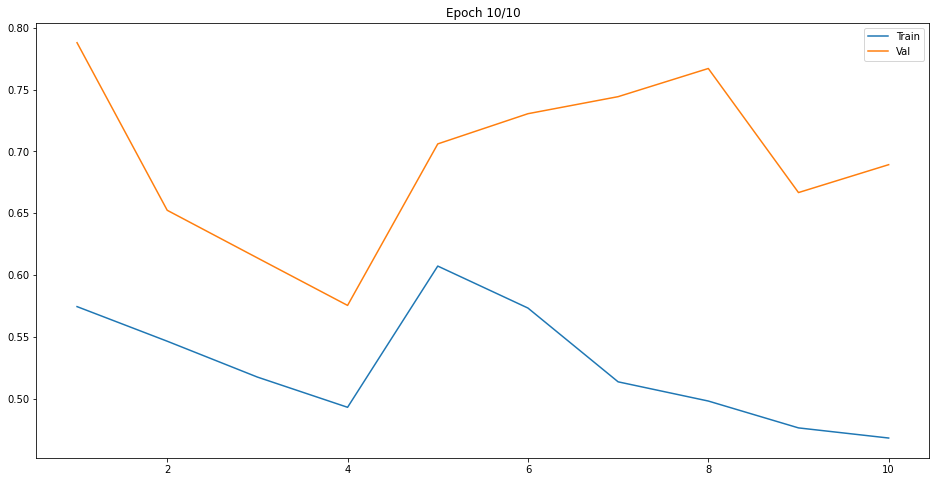

In [ ]:
train(vgg16, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [ ]:
test(vgg16, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.55      0.99      0.71      1030
         yes       0.95      0.22      0.35      1070

    accuracy                           0.60      2100
   macro avg       0.75      0.60      0.53      2100
weighted avg       0.76      0.60      0.53      2100



In [ ]:
test(vgg16, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.58      0.98      0.73       316
         yes       0.91      0.23      0.36       284

    accuracy                           0.62       600
   macro avg       0.75      0.60      0.55       600
weighted avg       0.74      0.62      0.56       600



In [ ]:
test(vgg16, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.55      0.99      0.71       154
         yes       0.91      0.14      0.25       146

    accuracy                           0.58       300
   macro avg       0.73      0.57      0.48       300
weighted avg       0.73      0.58      0.48       300



## CAM (Class Activation Map)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
def CAM(model, target_layer):
    fig = plt.figure(figsize=(25, 12))
    gs = fig.add_gridspec(int(np.ceil(vis_num_images / vis_images_per_row)), vis_images_per_row)
    for i in range(vis_num_images):
        sub_pl = fig.add_subplot(gs[i//vis_images_per_row, i % vis_images_per_row])
        sub_pl.set_title(f'{all_dataset.classes[vis_labels[i]]}', c=f'C{vis_labels[i]}')
        sub_pl.axis('off')

        Cam = GradCAMPlusPlus(model=model, target_layer=target_layer)
        Grayscale = Cam(input_tensor=preprocess_image(vis_images[i]).cuda())[0, :]
        visualization = show_cam_on_image(vis_images[i],mask=Grayscale)
        sub_pl.imshow(visualization)
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


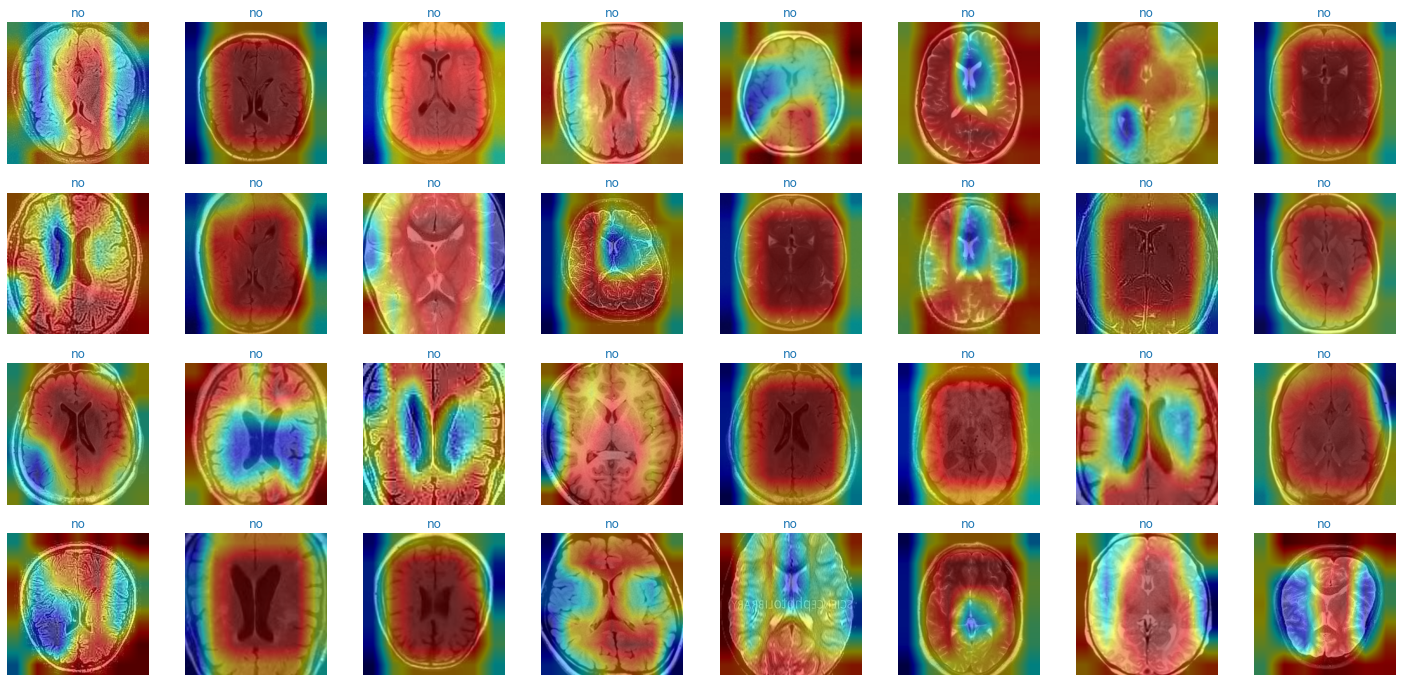

In [ ]:
CAM(vgg16, vgg16.conv_layers[-1])

# Transfer Learning

## Create Model

In [ ]:
vgg16_imagenet = None
vgg16_imagenet=ConvClassifier(input_shape=input_shape,num_classes=num_classes,convs='vgg16',fcs=fully_conected_array
                              , conv_drop_rate=conv_dropout, fc_drop_rate=fc_dropout)

vgg16_imagenet.to(DEVICE)
vgg16_imagenet

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


ConvClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): C

## Train

In [ ]:
optimizer = torch.optim.Adam(vgg16_imagenet.parameters(), lr=1e-3)

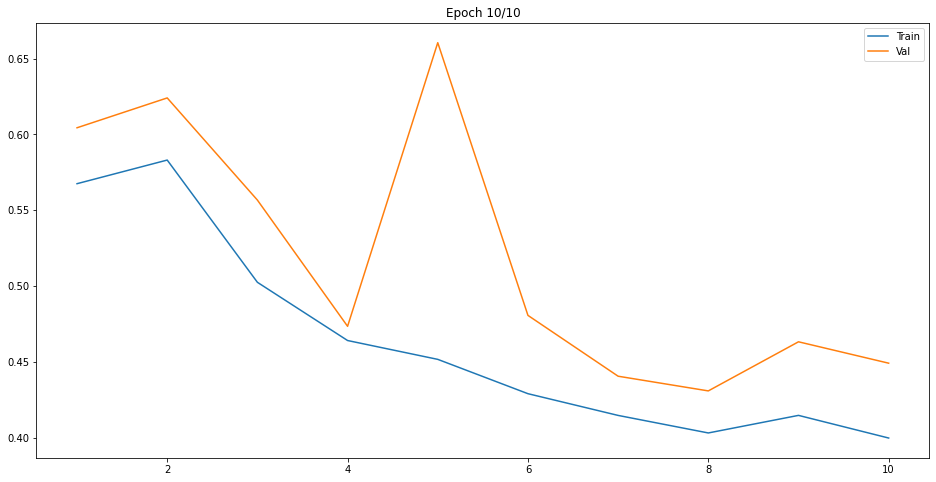

In [ ]:
train(vgg16_imagenet, train_loader, val_loader, optimizer, num_epochs=10)

## Test

In [ ]:
test(vgg16_imagenet, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.83      0.95      0.89      1030
         yes       0.95      0.82      0.88      1070

    accuracy                           0.88      2100
   macro avg       0.89      0.88      0.88      2100
weighted avg       0.89      0.88      0.88      2100



In [ ]:
test(vgg16_imagenet, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.86      0.93      0.90       316
         yes       0.92      0.83      0.87       284

    accuracy                           0.89       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.89      0.88       600



In [ ]:
test(vgg16_imagenet, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

          no       0.79      0.95      0.86       154
         yes       0.93      0.74      0.82       146

    accuracy                           0.85       300
   macro avg       0.86      0.84      0.84       300
weighted avg       0.86      0.85      0.84       300



## CAM (Class Activation Map)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


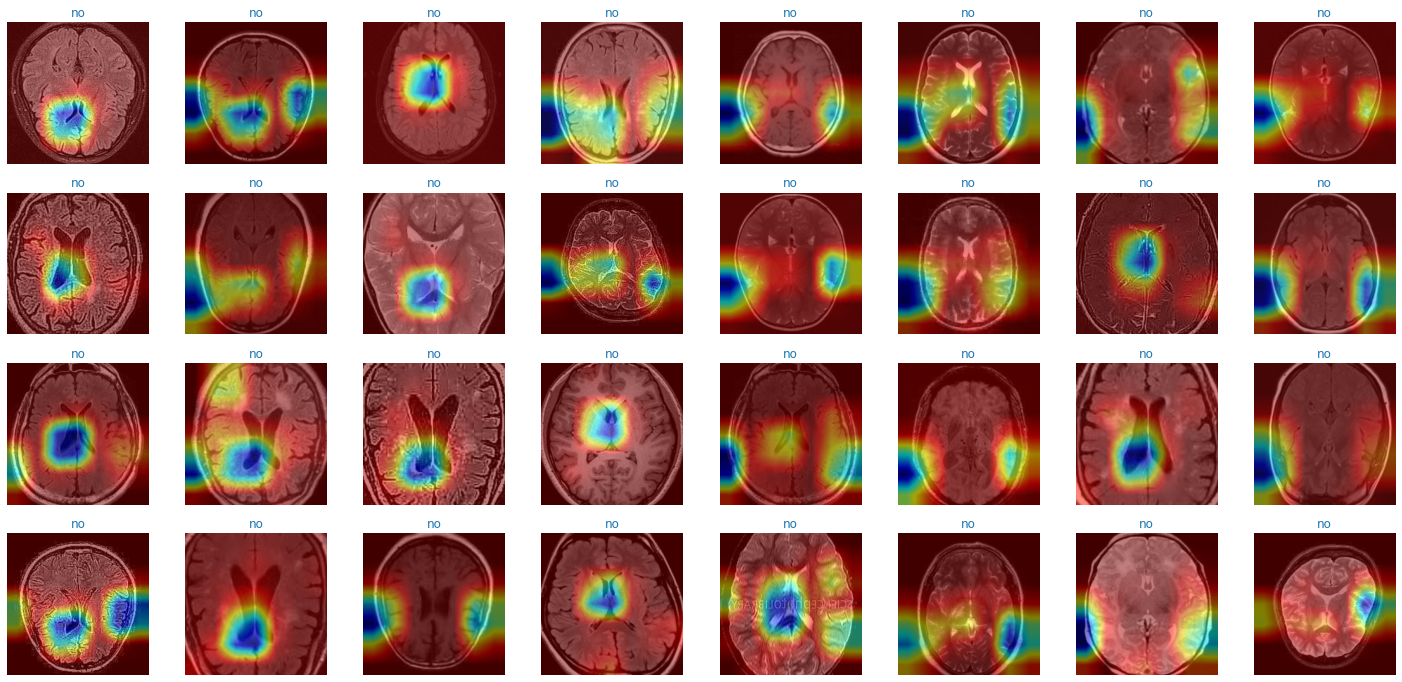

In [ ]:
CAM(vgg16_imagenet, vgg16_imagenet.conv_layers[-1])